In [3]:
import pandas as pd
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

articles = pd.read_csv("articles.CDKN2A.csv")
authors = pd.read_csv("authors.CDKN2A.csv")
paper = pd.read_csv("paper_counts.csv")

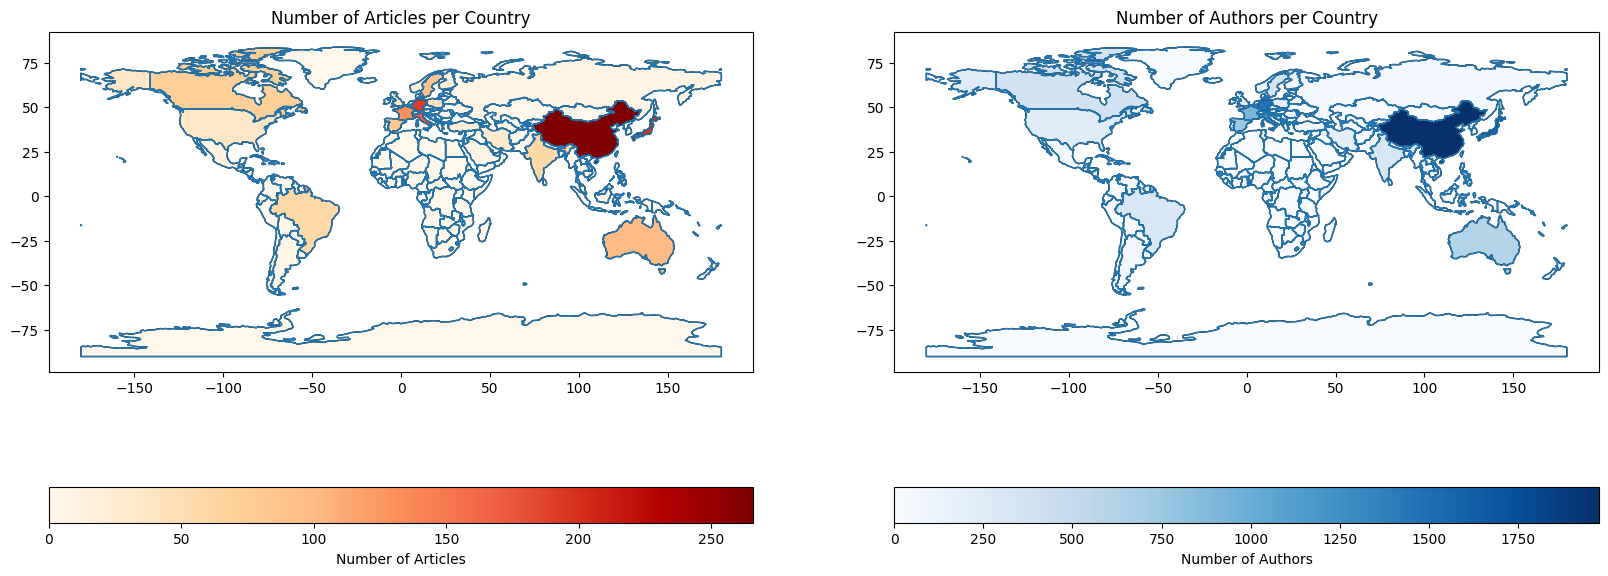

In [4]:
def extract_country(affiliation):
    """
    从作者单位信息中提取国家名。
    """
    if pd.isna(affiliation):
        return "Unknown"
    try:
        country = affiliation.split(',')[-1].strip()
        country = re.sub(r"(University|Institute|Hospital|Department|College|School).*$", "", country).strip()
        return country
    except:
        return "Unknown"

def clean_country_name(country):
    """
    清理提取出的国家名。
    """
    country = re.sub(r"\..*|\s\-\s.*", "", country)
    return country

# 应用函数到相关列
articles['articles_country'] = articles['FirstAuthorAffiliation'].apply(extract_country).apply(clean_country_name)
authors['authors_country'] = authors['AuthorAffiliation'].apply(extract_country).apply(clean_country_name)

# 按国家分组并计算文章和作者的数量
articles_count = articles['articles_country'].value_counts().reset_index()
articles_count.columns = ['Country', 'ArticleCount']

authors_count = authors['authors_country'].value_counts().reset_index()
authors_count.columns = ['Country', 'AuthorCount']

# 使用 geopandas 读取下载的 .shp 文件
world = gpd.read_file('mapdata/ne_110m_admin_0_countries.shp')

# 将计数与世界地图数据合并
world = world.merge(articles_count, left_on='ADMIN', right_on='Country', how='left')
world = world.merge(authors_count, left_on='ADMIN', right_on='Country', how='left')

# 用0填充NaN值
world['ArticleCount'] = world['ArticleCount'].fillna(0)
world['AuthorCount'] = world['AuthorCount'].fillna(0)

# 绘制地图：文章数量和作者数量
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# 文章数量地图
world.boundary.plot(ax=ax[0], linewidth=1)
world.plot(column='ArticleCount', ax=ax[0], legend=True,
           legend_kwds={'label': "Number of Articles", 'orientation': "horizontal"},
           cmap='OrRd', edgecolor='black')
ax[0].set_title('Number of Articles per Country')

# 作者数量地图
world.boundary.plot(ax=ax[1], linewidth=1)
world.plot(column='AuthorCount', ax=ax[1], legend=True,
           legend_kwds={'label': "Number of Authors", 'orientation': "horizontal"},
           cmap='Blues', edgecolor='black')
ax[1].set_title('Number of Authors per Country')

plt.show()



In [5]:
print(world.columns)


Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_IT', 'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA',
       'geometry', 'Country_x', 'ArticleCount', 'Country_y', 'AuthorCount'],
      dtype='object', length=173)


In [9]:
def extract_country(affiliation):
    """
    从作者单位信息中提取国家名。
    """
    if pd.isna(affiliation):
        return "Unknown"
    try:
        country = affiliation.split(',')[-1].strip()
        country = re.sub(r"(University|Institute|Hospital|Department|College|School).*$", "", country).strip()
        return country
    except:
        return "Unknown"

def clean_country_name(country):
    """
    清理提取出的国家名。
    """
    country = re.sub(r"\..*|\s\-\s.*", "", country)
    return country

# 应用函数到相关列
articles['articles_country'] = articles['FirstAuthorAffiliation'].apply(extract_country).apply(clean_country_name)
authors['authors_country'] = authors['AuthorAffiliation'].apply(extract_country).apply(clean_country_name)

# 按国家分组并计算文章和作者的数量
articles_count = articles['articles_country'].value_counts().reset_index()
articles_count.columns = ['Country', 'ArticleCount']

authors_count = authors['authors_country'].value_counts().reset_index()
authors_count.columns = ['Country', 'AuthorCount']

# 使用 geopandas 读取下载的 .shp 文件
world = gpd.read_file('mapdata/ne_110m_admin_0_countries.shp')

# 将计数与世界地图数据合并
world = world.merge(articles_count, left_on='ADMIN', right_on='Country', how='left')
world = world.merge(authors_count, left_on='ADMIN', right_on='Country', how='left')

# 用0填充NaN值
world['ArticleCount'] = world['ArticleCount'].fillna(0)
world['AuthorCount'] = world['AuthorCount'].fillna(0)

# 创建基本地图
m = folium.Map(
    location = [0, 0], # Set the map center position coordinates [latitude, longitude] # 设定地图中心位置坐标 [纬度, 经度] 
    zoom_start = 2, # Set initial zoom level # 设定初始缩放级别 
    min_zoom = 2, # Set minimum zoom level # 设定最小缩放级别 
    max_bounds = True, # Turn on the maximum boundary limit of the map # 开启地图最大边界限制
    min_lon = -180, # Set the minimum longitude value # 设定最小经度值
    max_lon = 180, # Set the maximum longitude value # 设定最大经度值
    min_lat = -90, # Set the minimum latitude value # 设定最小纬度值
    max_lat = 90 # Set the maximum latitude value # 设定最大纬度值
)

# 将 GeoDataFrame 转换为 GeoJSON
world_geojson = world.to_json()

# 添加一个图层，使用 GeoJSON 数据
folium.Choropleth(
    geo_data=world_geojson,
    name='choropleth',
    data=world,
    columns=['ADMIN', 'ArticleCount'],
    key_on='feature.properties.ADMIN',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_weight=0.3,
    legend_name='Number of Articles'
).add_to(m)

# 添加工具提示
folium.GeoJson(
    world_geojson,
    name='Countries',
    tooltip=folium.GeoJsonTooltip(
        fields=['ADMIN', 'ArticleCount', 'AuthorCount'],
        aliases=['Country', 'Number of Articles', 'Number of Authors'],
        localize=True
    )
).add_to(m)

# 保存地图为 HTML 文件
m.save('my_map.html')
